# **Inteligencja obliczeniowa w analizie danych cyfrowych**

## **Projekt 5: Przestrzenie ciągłe**

Autorzy: Karolina Surówka, Weronika Hilaszek

Import i instalacja potrzebnych bibliotek

In [12]:
%pip install stable_baselines3

Note: you may need to restart the kernel to use updated packages.


In [13]:
import gymnasium as gym
from stable_baselines3 import A2C
import matplotlib.pyplot as plt
import time
import numpy as np

#### **Zadania na 3.0**

**Wprowadzenie** 

Środowisko **Pendulum-v1** jest częśćią klasycznym problemów kontrolnych, polega na kontrolowaniu odwróconego wahadła poprzez zastosowanie momentu obrotowego, aby unieść je do pozycji pionowej. Przestrzeń akcji obejmuje wartości momentu od -2.0 do 2.0, natomiast przestrzeń obserwacji obejmuje współrzędne x-y i prędkość kątową. Akcje w środowisku są ciągłe i odpowiadają momentom siły stosowanym na wahadło. Funkcja nagrody karze za odchylenia od pozycji pionowej, wysoką prędkość kątową i duży moment obrotowy. Epizody trwają do 200 kroków czasowych, zaczynając od losowych kątów i prędkości. Domyślne przyspieszenie grawitacyjne wynosi 10,0 m/s², można je również dostosować (u nas jest to 9.81)

**Algorytm A2C** (Advantage Actor-Critic) to wariant Actor-Critic, który wprowadza funkcję przewagi (advantage), mierzącą różnicę między daną akcją a przeciętną akcją w danym stanie. A2C działa poprzez interakcję agenta ze środowiskiem, obliczanie funkcji przewagi, a następnie aktualizację parametrów aktora i krytyka.  
**Actor**: odpowiedzialny za wybór akcji na podstawie polityki.  
**Critic**: ocenia wartość stanu, pomagając w aktualizacji polityki.  

##### **Hiperparametry:**    
**learning_rate** : szybkość uczenia, określa jak duże kroki algorytm wykonuje podczas aktualizacji parametrów modelu  
**gamma** : współczynnik dyskontowania, określa, jak bardzo przyszłe nagrody są brane pod uwagę podczas obliczania wartości bieżącej polityki  
**ent_coef** : współczynnik entropii, używany do regulacji entropii w celu promowania eksploracji w algorytmie  
**n_timesteps** : liczba kroków czasowych, określa całkowitą liczbę interakcji agenta ze środowiskiem podczas treningu  
**policy** : polityka okreśka architekturę sieci neuronowej używanej przez agenta do podejmowania decyzji  
**n_runs** : liczba uruchomień, liczba niezależnych eksperymentów

Wykorzystane przez nas zestawy hiperparametrów:

In [14]:
param_sets = [
    {"learning_rate": 0.0003, "gamma": 0.99, "ent_coef": 0.01},
    {"learning_rate": 0.0007, "gamma": 0.95, "ent_coef": 0.05},
    {"learning_rate": 0.001, "gamma": 0.9, "ent_coef": 0.1}
]

In [15]:
n_timesteps = 50000
policy = "MlpPolicy"
n_runs = 10

In [16]:
class A2CModel:
    def __init__(self, policy, env, learning_rate=0.0007, n_steps=5, gamma=0.99, gae_lambda=1.0, ent_coef=0.0, vf_coef=0.5, max_grad_norm=0.5, rms_prop_eps=1e-05, use_rms_prop=True):
        self.policy = policy
        self.env = env
        self.learning_rate = learning_rate
        self.n_steps = n_steps
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef
        self.max_grad_norm = max_grad_norm
        self.rms_prop_eps = rms_prop_eps
        self.use_rms_prop = use_rms_prop

    def get_model(self):
        return A2C(self.policy, self.env, learning_rate=self.learning_rate, n_steps=self.n_steps, gamma=self.gamma, gae_lambda=self.gae_lambda, ent_coef=self.ent_coef, vf_coef=self.vf_coef, max_grad_norm=self.max_grad_norm, rms_prop_eps=self.rms_prop_eps, use_rms_prop=self.use_rms_prop)


In [17]:
class LearningParams:
    def __init__(self, total_timesteps=50000, callback=None, log_interval=100, tb_log_name="A2C", reset_num_timesteps=True, progress_bar=False):
        self.total_timesteps = total_timesteps
        self.callback = callback
        self.log_interval = log_interval
        self.tb_log_name = tb_log_name
        self.reset_num_timesteps = reset_num_timesteps
        self.progress_bar = progress_bar

In [18]:
def learn_and_collect_rewards(model, params: LearningParams):
    model.learn(total_timesteps=params.total_timesteps, callback=params.callback, log_interval=params.log_interval, tb_log_name=params.tb_log_name, reset_num_timesteps=params.reset_num_timesteps, progress_bar=params.progress_bar)
    env = model.get_env()
    obs = env.reset()
    ep_rewards = []
    rewards = []
    for _ in range(params.total_timesteps):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
            obs = env.reset()
            ep_rewards.append(np.sum(rewards))
            rewards = []
    if rewards:
        ep_rewards.append(np.sum(rewards))
    return ep_rewards

In [19]:
env_id = 'Pendulum-v1'
env = gym.make(env_id, g=9.81)

In [20]:
def play(params: LearningParams, model_class):
    all_rewards = []
    times = []
    for _ in range(n_runs):
        model = model_class.get_model()
        start_time = time.time()
        rewards = learn_and_collect_rewards(model, params=params)
        end_time = time.time()
        all_rewards.append(rewards)
        times.append((end_time - start_time) / len(rewards)) 
    return all_rewards, times

In [21]:
params = LearningParams(total_timesteps=n_timesteps)
results = []
execution_times = []

In [22]:
for param_set in param_sets:
    model_class = A2CModel(policy, env, **param_set)
    all_rewards, times = play(params=params, model_class=model_class)
    
    rewards_array = np.array(all_rewards)
    mean_rewards = np.mean(rewards_array, axis=0)
    std_rewards = np.std(rewards_array, axis=0)
    
    results.append((mean_rewards, std_rewards))
    execution_times.append(np.mean(times))

Zobrazowanie średniej i odchylenia standardowego

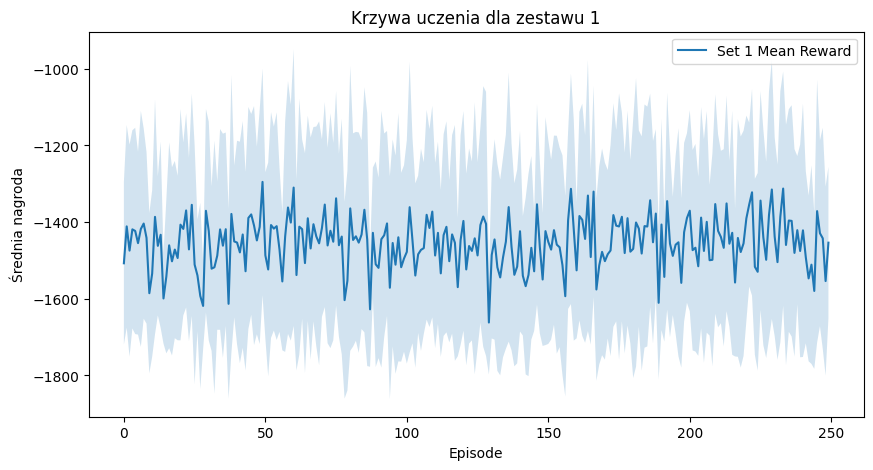

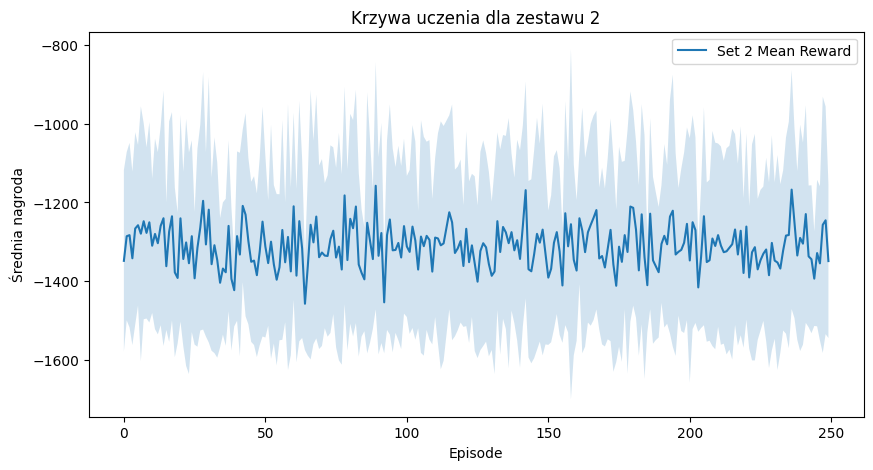

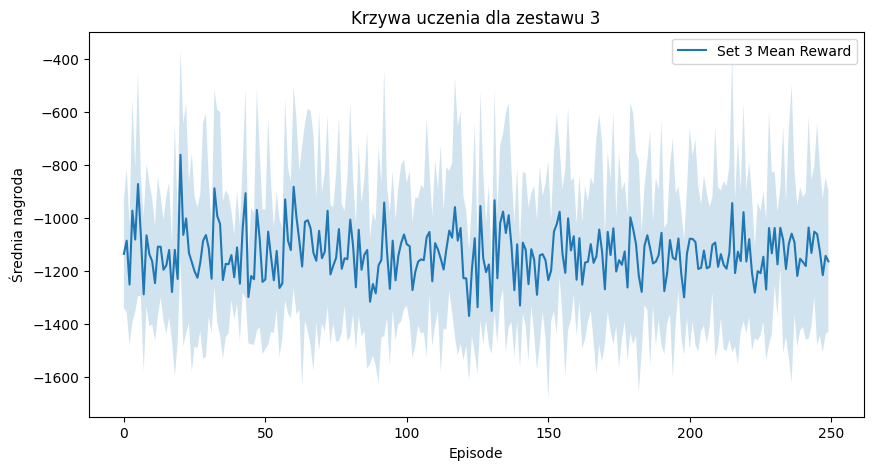

In [23]:
for i, (mean_rewards, std_rewards) in enumerate(results):
    plt.figure(figsize=(10, 5))
    plt.plot(mean_rewards, label=f'Set {i+1} Mean Reward')
    plt.fill_between(range(len(mean_rewards)), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2)
    plt.xlabel('Episode')
    plt.ylabel('Średnia nagroda')
    plt.title(f'Krzywa uczenia dla zestawu {i+1}')
    plt.legend()
    plt.show()

#### **Wnioski**

Zestaw 3 wydaje się być nieco lepszy od zestawów 1 i 2. Średnia nagroda jest wyższa (bliżej zera) i krzywa uczenia jest bardziej stabilna, z mniejszą ilością skrajnych wahań.
Zestawy 1 i 2 mają podobną wydajność, zarówno pod względem nagrody, jak i stabilności. Nie ma wyraźnego rozróżnienia między tymi dwoma zestawami.
Czas wykonania jest bardzo zbliżony dla wszystkich trzech zestawów, przy czym Zestaw 3 jest nieco szybszy, co może również zaznaczać jego przewagę.

In [24]:
print("Średni czas wykonania epizodu dla każdego zestawu hiperparametrów:")
for i, time in enumerate(execution_times):
    print(f"Zestaw {i+1}: {time:.5f} sekund")

Średni czas wykonania epizodu dla każdego zestawu hiperparametrów:
Zestaw 1: 0.35708 sekund
Zestaw 2: 0.35737 sekund
Zestaw 3: 0.34963 sekund


Średni czas wykonania epizodu jest dość zbliżony dla wszystkich trzech zestawów, oscylując wokół 0.35 sekundy. 